# Generating the Lyrics Project
### In this project, I will build a model to generate the lyrics through Recurrent Neural Networks(RNN).

# Index
### 1. Importing Libraries / Loading Data

### 2. Data Exploration

### 3. Data Preprocessing

### 4. Building Model

### 5. Evaluating Models

### 6. Conclusion

### 7. End

## Step1. Importing Libraries / Loading Data from Kaggle Dataset 
- Link: https://www.kaggle.com/datasets/joebeachcapital/57651-spotify-songs/code
- This Dataset came from the Spotify Music with the column atrist, song, link, and text. This data have 57650 rows.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from wordcloud import WordCloud, STOPWORDS
from keras.models import Sequential
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.optimizers import Adamax
import seaborn as sns

In [23]:
df = pd.read_csv('/Users/admin/Downloads/ProjectHW/Spotify Million Song Dataset_exported.csv')
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [24]:
df.drop('link',inplace=True, axis=1)
df = df.rename(columns={'text': 'lyrics'})
df['lyrics'] = df['lyrics'].str.replace('\n', '')
df.head()

,artist,song,lyrics
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face And i..."
1,ABBA,"Andante, Andante","Take it easy with me, please Touch me gently ..."
2,ABBA,As Good As New,I'll never know why I had to go Why I had to ...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


## Step2. Data Exploration
- The most songs artists
- The number of songs and columns
- Generate a word cloud image

- The most songs artists

In [25]:
df.groupby('artist').agg({'song':'count'}).sort_values('song',ascending=False)

,song
artist,
Donna Summer,191
Gordon Lightfoot,189
Bob Dylan,188
George Strait,188
Cher,187
...,...
Exo-K,2
U-Kiss,1
X-Treme,1


- The number of songs and columns

In [26]:
print(df.shape)

(57650, 3)


- Generate a word cloud image

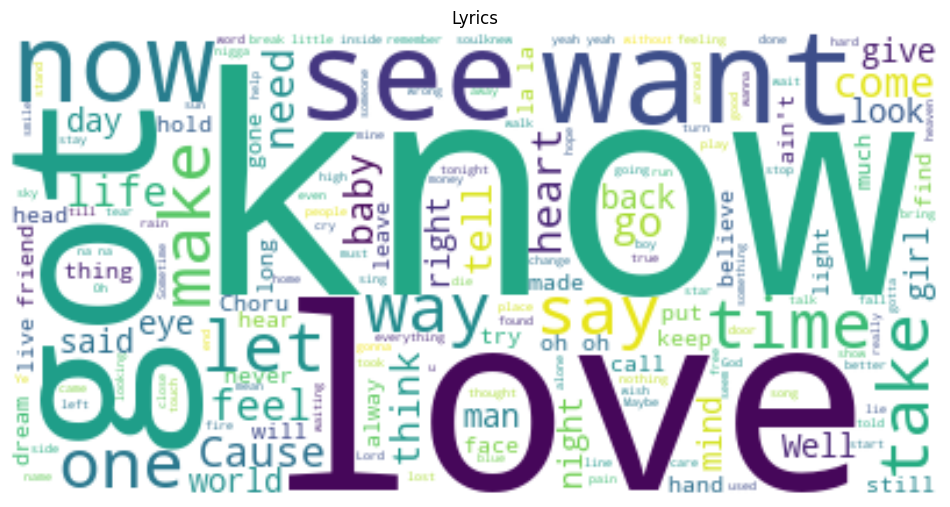

In [6]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=800).generate(" ".join(df["lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Lyrics')
plt.show()

## Step3. Data Preprocessing
- In order to acclerate the training time, randomly delete some row.
- Creating a Corpus of Lyrics text
- Removing the unrequired characters that may have sneaked in my text corpus
- Creating a dictionary to map characters and their indices
- Splitting the corpus into smaller sentences of equal length

- In order to acclerate the training time, randomly delete some row.

In [53]:
keep_fraction = 0.125
total_rows = len(df)
keep_rows = int(total_rows * keep_fraction)

random_indices = df.sample(n=keep_rows, random_state=42).index

df2 = df.loc[random_indices]


- Creating a Corpus of Lyrics text

In [54]:
print(df2.lyrics)

56679    Like to have you 'round  With all the lies tha...
224      This Little Light of Mine (Light of Mine),  I'...
32457    She says she's no good with words but I'm wors...
9167     Hey mama, mama, come a look at sister,  She's ...
13270    I see it all through my window it seems.  Neve...
                               ...                        
46086    All alone in a sleepless night  Passing time w...
10393    Once in A lifetime  Kenny Loggins and Human Na...
30968    I'm feeling mighty lonesome  Haven't slept a w...
49319    I took my baby dancing, to see a heavy band  B...
49602    Now I've got a chick who will be with me  Anyt...
Name: lyrics, Length: 7206, dtype: object


In [55]:
Corpus =''
for listitem in df2.lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 

In [56]:
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 49


- Removing the unrequired characters

In [57]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: [' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [58]:
ready_to_move = ['!', '(', ')', ':', '?', '[', ']', '-', '\n']
for symbol in ready_to_move:
    Corpus = Corpus.replace(symbol," ")

In [59]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: [' ', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


- Creating a dictionary to map characters and their indices

In [60]:
symb = sorted(list(set(Corpus)))

#length of corpus
L_corpus = len(Corpus) 

#length of total unique characters
L_symb = len(symb) 

#Building dictionary to access the vocabulary from indices
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 8245298
Number of unique characters: 41


- Splitting the corpus into smaller sentences of equal length

In [61]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 8245258


## Step4. Model Training
In this project, I will be using a LSTM Model. This is an improved version of the recurrent neural network

- Initialising the Model
- Defining by adding layers
- Compiling the Model
- Training the Model


Encoding the Labels and Targets

In [62]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)

# one hot encode the output variable
y = tf.keras.utils.to_categorical(targets)

In [63]:
start_time = time.time()

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))

opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)
model.summary()

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
print(f"Total Time：{elapsed_time} second")
print(f"Total Time：{elapsed_minutes} minutes")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               264192    
                                                                 
 dense_3 (Dense)             (None, 41)                10537     
                                                                 
Total params: 274729 (1.05 MB)
Trainable params: 274729 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Total Time：0.5680482387542725 second
Total Time：0.00946747064590454 minutes


- Training Model (I trained this model within 1050 minutes)

In [64]:
history = model.fit(X, y, batch_size=128, epochs=5)

Epoch 1/5
64417/64417 [==============================] - 13786s 214ms/step - loss: 1.9511
Epoch 2/5
64417/64417 [==============================] - 13286s 206ms/step - loss: 1.6725
Epoch 3/5
64417/64417 [==============================] - 13742s 213ms/step - loss: 1.5913
Epoch 4/5
64417/64417 [==============================] - 12358s 192ms/step - loss: 1.5450
Epoch 5/5
64417/64417 [==============================] - 10061s 156ms/step - loss: 1.5123


## Step5. Evaluating Models
I had the model from step4. I can generate the lyrics from this model, and I also check the performence about this model.

/Users/admin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/admin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/admin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/admin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

[Text(0.5, 0, 'Epochs')]

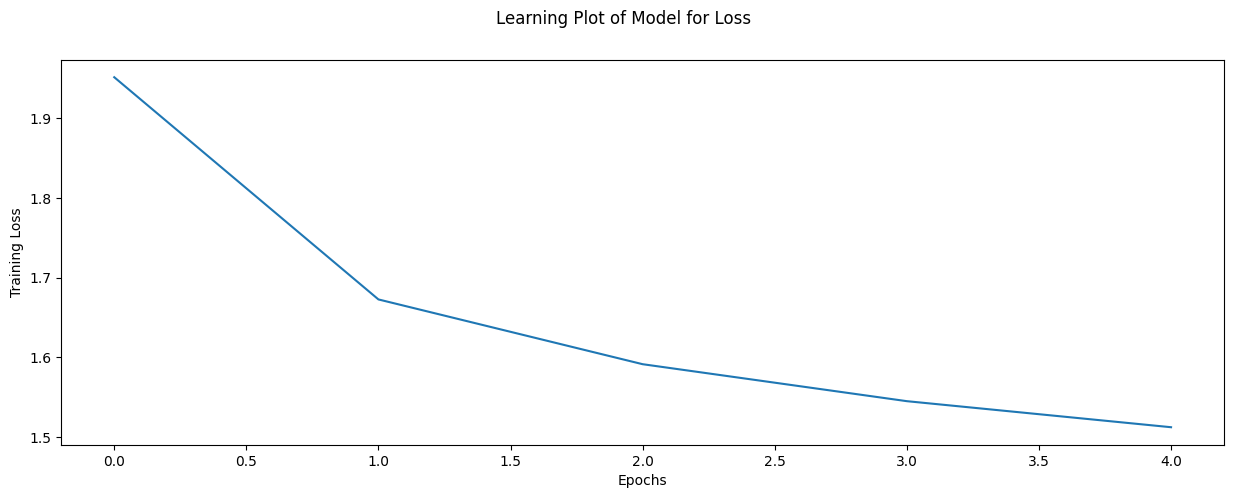

In [68]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [94]:
def Lyrics_Generator(starter, Ch_count, temperature=1.0):
    generated = ""
    starter = starter
    seed = [mapping[char] for char in starter]
    generated += starter
    # Generating new text of given length
    for i in range(Ch_count):
        seed = [mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred / float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]
        # Adjusting the prediction with temperature
        prediction = np.log(prediction) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        # Adding some randomness to character selection
        index = np.random.choice(len(symb), p=prediction)
        next_char = reverse_mapping[index]
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char

    return generated

- Testing the lyrics from Inoj - All I Want

In [104]:
#Generating a song from the model
Lyrics_1 = Lyrics_Generator("all i want is your love. can you give it to me.", 400, temperature=0.5)

print(Lyrics_1)

all i want is your love. can you give it to me.     mont iu said  ly menory  i met you with a siceoal to the ban the saie  when i ball and the lifht  it could be loving let you down  hnw i cenebrate  and it is a cediaen  she was loving you    and i want to see you honey  and i can't never tell you  i don't want to ree me    body tr dven     chorus     gather tert  and her way a lot hnme  ho the kid and the hole  that is tticy  hnne ia make you


- Testing the lyrics from Utada - Come Back To Me

In [102]:
#Generating a song from the model
Lyrics_2 = Lyrics_Generator("come back, baby, come back to me come back, i'll be everything you need come back, baby, come back to me come back, boy, you're one in a million", 400, temperature=0.5)

print(Lyrics_2)

/var/folders/cs/3cj4mwls50n3nbcs9g57bnjw0000gn/T/ipykernel_59407/2750663707.py:38: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / temperature


come back, baby, come back to me come back, i'll be everything you need come back, baby, come back to me come back, boy, you're one in a million domra  i'll be the one  that i got to say  you lnok aia me    i can tell you  when i'm said it would be sure  and i can't be forever  i got you  i know you're gonna take it  you are the oaie i'm ttyen  i can take your daddy    the simgen welt  no more     chorus     i wanna bring my eas     chorus   ooe more day     chorus     it aln on the batke     chorus     i want to bale     you got to ball 


- Testing the lyrics from Baby Shark

In [103]:
#Generating a song from the model
Lyrics_3 = Lyrics_Generator("baby shark do do do do do do baby.", 400, temperature=0.5)

print(Lyrics_3)


/var/folders/cs/3cj4mwls50n3nbcs9g57bnjw0000gn/T/ipykernel_59407/2750663707.py:38: RuntimeWarning: divide by zero encountered in log
  prediction = np.log(prediction) / temperature


baby shark do do do do do do baby.  i mean you     chorus     i danned and your little plan    i'm a long time with you  i can't see you    i want to be alone and i'm all of the times  and it is the poor i hold  and the sticks of shiv  stand and a bring of hills,  she was a man come and ball    and i'm the pnece and i lig  roml in the broken heart to for the world  where the things that i keep  the talgng she lnoks and it can say 


## Step6. Conclusion



I used one-eighth of data in the dataset for training in order to decrease the training time.

Based on the trend in the Learning Plot of Model for Loss(Step4.), the model's performance is improving over time, which is indicated by the descending line. 

This suggests that the loss is decreasing as the number of epochs increases, which is typically a good sign in model training. 

A decreasing loss means that the model is learning from the training dataset and is getting better at making predictions.



After I trained the model, I used the most words like "love", "want", and "come" to evaluate this model. I also used not common word "shark" for evaluating.

I found that the words with common words. The lyrics will perform better than the lyrics that with the uncommon word. 

Even though the result of lyrics seems not good. I believe that we can use the model that training for a long time to get the better result.

## End 